In [1]:
# DATA CLEANING AND PREPARATION STAGE (PANDAS)

import pandas as pd
df = pd.read_csv("imdb_top_1000.csv")

print(df.head(1)) # the first lines
print(df.shape) # number of rows and columns
print(df.columns) # sütun isimleri (column names)
print(df.info())
print(
    "\n The number of missing values \n", df.isna().sum()
)

df.columns = df.columns.str.strip() # Clear unnecessary gaps and format errors

# Fill missing values in the "Certificate" column with "unknown"
df["Certificate"] = df["Certificate"].fillna(
    "unknown"
)

# Fill missing values with the median of the column
df["Meta_score"] = df["Meta_score"].fillna(
    df["Meta_score"].median() # is preferred not to be affected by outlier values (Meta_score = 0-100)
)

# Convert the "Gross" column to numbers (remove commas, replace missing values with 0)
df["Gross"] = df["Gross"].fillna(
    df["Gross"].mode()[0] # fills missing values with the most common value of the column (en sık görülen değerle doldurur)
)
df["Gross"] = df["Gross"].astype(str).str.replace(",", "").astype(float) # Remove commas and convert to float

# object -> numeric and setting errors to NaN
df["Released_Year"] = pd.to_numeric( # Convert to numeric
    df["Released_Year"],
    errors="coerce" # If conversion fails, set as NaN
)

# Filling NaN's with the average
mean_year = df["Released_Year"].mean()
df["Released_Year"] = df["Released_Year"].fillna(
    mean_year
)

# numeric -> int
df.Released_Year = df.Released_Year.astype('int64')

# object -> category
colomuns = ["Certificate", "Genre"]
for i in colomuns:
    df[i] = df[i].astype("category")

# object -> string -> int
df["Runtime"] = df["Runtime"].astype(str).str.replace(" min", "").astype('int64')

print(
    "\nAfter cleaning, data info:\n", df.dtypes
)
print(
    "\n The number of missing values \n", df.isna().sum()
)

                                         Poster_Link  \
0  https://m.media-amazon.com/images/M/MV5BMDFkYT...   

               Series_Title Released_Year Certificate  Runtime  Genre  \
0  The Shawshank Redemption          1994           A  142 min  Drama   

   IMDB_Rating                                           Overview  Meta_score  \
0          9.3  Two imprisoned men bond over a number of years...        80.0   

         Director        Star1           Star2       Star3           Star4  \
0  Frank Darabont  Tim Robbins  Morgan Freeman  Bob Gunton  William Sadler   

   No_of_Votes       Gross  
0      2343110  28,341,469  
(1000, 16)
Index(['Poster_Link', 'Series_Title', 'Released_Year', 'Certificate',
       'Runtime', 'Genre', 'IMDB_Rating', 'Overview', 'Meta_score', 'Director',
       'Star1', 'Star2', 'Star3', 'Star4', 'No_of_Votes', 'Gross'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   

Correlation Matrix:
             Gross  IMDB_Rating  Meta_score  No_of_Votes
Gross         1.00         0.08       -0.06         0.60
IMDB_Rating   0.08         1.00        0.26         0.49
Meta_score   -0.06         0.26        1.00        -0.03
No_of_Votes   0.60         0.49       -0.03         1.00


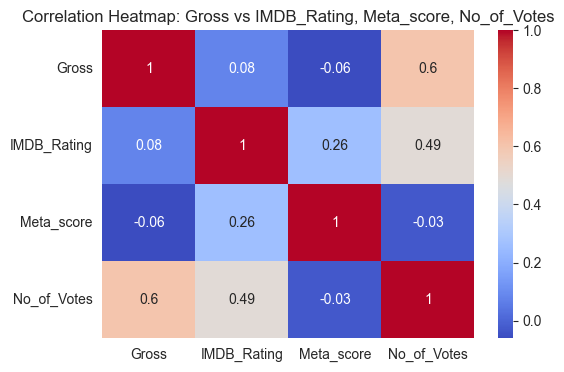


---Correlation Analysis Report---
 Viewer interest (No_of_Votes) increases financial success (Gross) the most
 The IMDB rating shows a relatively weak effect, while the Meta_score has a negative effect
 As a result, popularity appears to be more effective than quality in determining financial success


In [2]:
# Correlation for to see the effect of quality, popularity on financial success

import matplotlib.pyplot as plt
import seaborn as sns

df_corr = df[
    ["Gross", "IMDB_Rating", "Meta_score", "No_of_Votes"]
]
corr = df_corr.corr().round(2) # sonuçlarda virgülden sonra sadece 2 basamak gösterilir
print("Correlation Matrix:")
print(corr)

# Heatmap
plt.figure(figsize=(6,4))
sns.heatmap(
    corr,
    annot=True, # her hücrenin içine rakam olarak korelasyon değerini yazar
    cmap="coolwarm"
)
plt.title("Correlation Heatmap: Gross vs IMDB_Rating, Meta_score, No_of_Votes")
plt.show()

print(
    "\n---Correlation Analysis Report---\n",
    "Viewer interest (No_of_Votes) increases financial success (Gross) the most\n",
    "The IMDB rating shows a relatively weak effect, while the Meta_score has a negative effect\n"
    " As a result, popularity appears to be more effective than quality in determining financial success"
)

Range of the Years in the Quarter Periods:
Q1 - 1920 - 1976
Q2 - 1977 - 1999
Q3 - 2000 - 2009
Q4 - 2010 - 2020


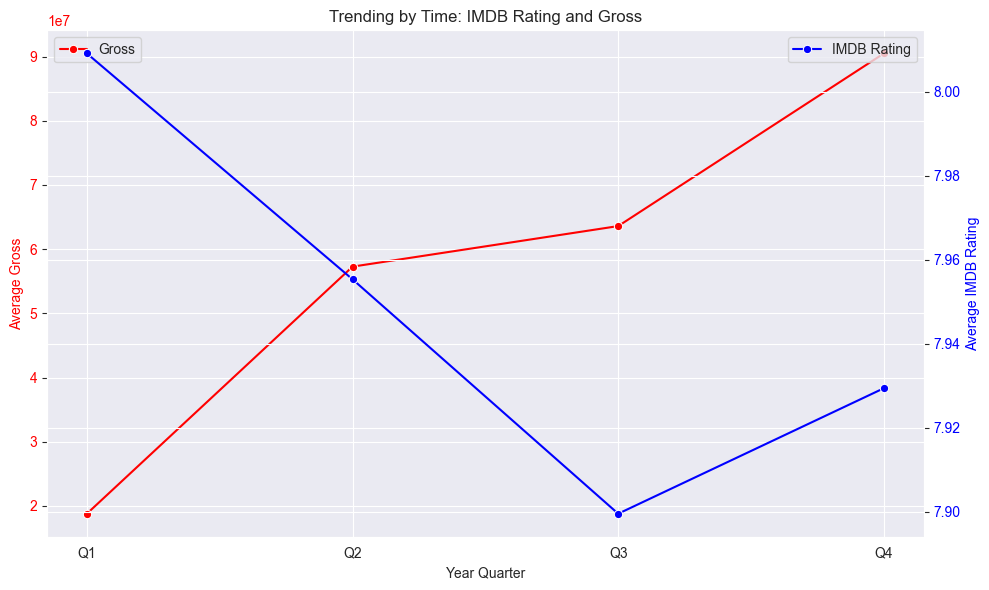

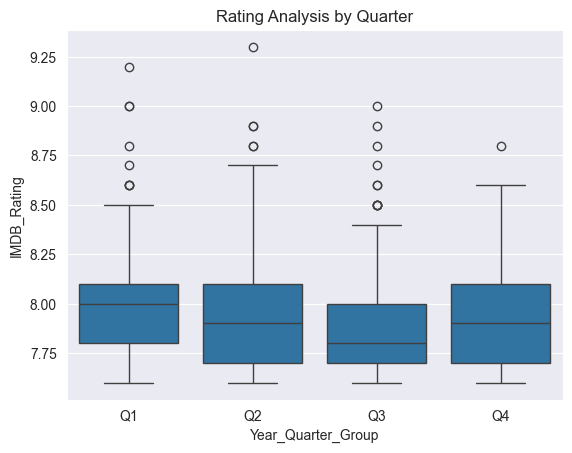

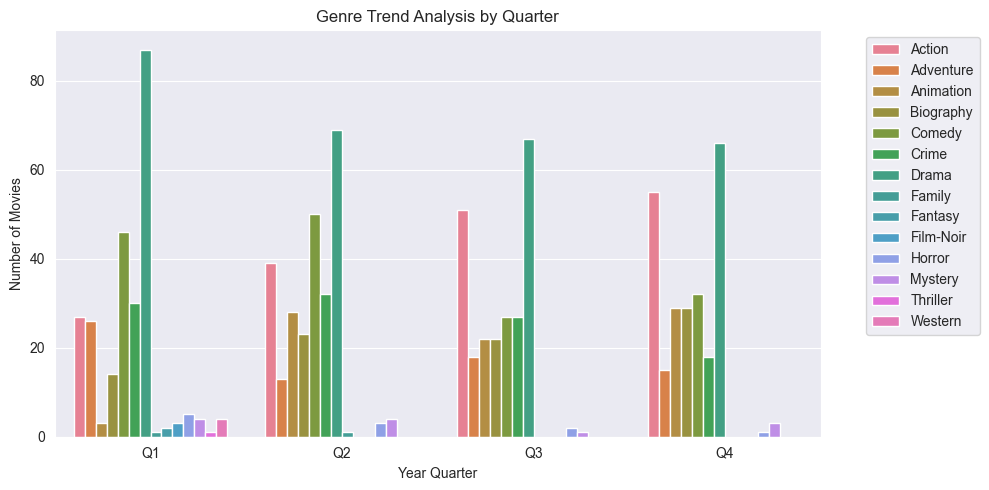

In [3]:
# ANALYZE TRENDS OVER TİME

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Divide Years into 4 Quarters
df = df.sort_values("Released_Year") # Yıllara göre sıralar
df["Year_Quarter_Group"] = pd.qcut( # pd.qcut = veri serisini belirtilen sayıda eşit büyüklükte gruplara bölmek için kullanılır
    df["Released_Year"],
    q=4,
    labels=["Q1", "Q2", "Q3", "Q4"]
)

# Range of the Years in the Quarter Periods
quanter_ranges = df.groupby("Year_Quarter_Group")["Released_Year"].agg(["min", "max"]).reset_index() # .agg() = Aggregate (Özetleme) Fonksiyonu
print("Range of the Years in the Quarter Periods:")
for _, row in quanter_ranges.iterrows(): # .iterrows() = Satır Satır Dolaşır
    print(
        f"{row['Year_Quarter_Group']}"
        f" - {row['min']}"
        f" - {row['max']}"
    )

# TRENDİNG BY TİME: IMDB RATİNG AND GROSS

trend = df.groupby("Year_Quarter_Group")[
    ["IMDB_Rating", "Gross"]
].mean().reset_index() # ortalamalar hesaplanıp, ortalamaları veri çerçevesine dönüştürüp yeni sütuna ekler

# Making Graph
fig, ax1 = plt.subplots( # birden fazla grafiği tek bir figürde yan yana veya üst üste göstermek için kullanılır
    figsize=(10,6)
)

# Left Axis - Gross
sns.lineplot( # (ax1) çizgi grafiğini özelleştirir
    data=trend,
    x="Year_Quarter_Group",
    y="Gross",
    marker="o",
    color="red",
    label="Gross",
    ax=ax1
)
ax1.set_xlabel("Year Quarter")
ax1.set_ylabel("Average Gross", color="red")
ax1.tick_params( # görsel bir bilgi sunar(kırmızı etiket Gross'a aittir)
    axis="y",
    labelcolor="red"
)

# Right Axis - IMDB Rating
ax2 = ax1.twinx() # iki farklı veri setini aynı grafik üzerinde görselleştirmek için faydalıdır
sns.lineplot(
    data=trend,
    x="Year_Quarter_Group",
    y="IMDB_Rating",
    marker="o",
    color="blue",
    label="IMDB Rating",
    ax=ax2
)
ax2.set_ylabel(
    "Average IMDB Rating",
    color="blue"
)
ax2.tick_params(
    axis="y",
    labelcolor="blue"
)

plt.title("Trending by Time: IMDB Rating and Gross")
fig.tight_layout()
plt.show()

# RATING ANALYSIS BY QUARTER

sns.boxplot(
    data=df,
    x="Year_Quarter_Group",
    y="IMDB_Rating"
)
plt.title("Rating Analysis by Quarter")
plt.show()

# GENRE TREND ANALYSIS BY QUARTER

df["Main_Genre"] = df["Genre"].str.split(",").str[0] # ilk türü alır
genre_trend = (
    df.groupby(
        ["Year_Quarter_Group", "Main_Genre"],
        observed=True
    )
    .size()
    .reset_index(name="Count")
)
plt.figure(figsize=(10,5))
sns.barplot(
    data=genre_trend,
    x="Year_Quarter_Group",
    y="Count",
    hue="Main_Genre"
)
plt.title("Genre Trend Analysis by Quarter")
plt.xlabel("Year Quarter")
plt.ylabel("Number of Movies")
plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)
plt.tight_layout()
plt.show()

Min Vote: 25088 - Movie Name: Ba wang bie ji
Max Vote: 2343110 - Movie Name: The Shawshank Redemption
Popularity_Category
Low       334
High      334
Medium    332
Name: count, dtype: int64


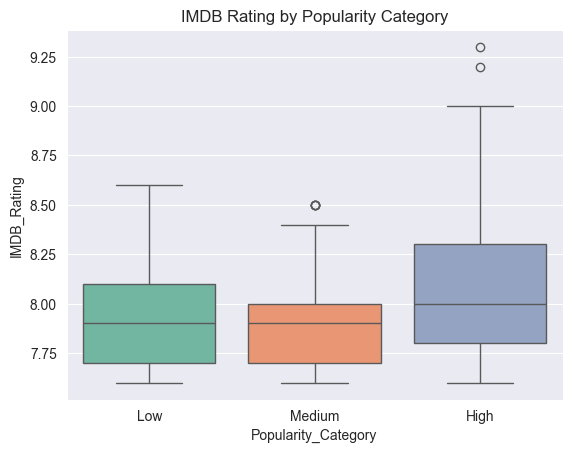

Average IMDB Rating Values for Each Popularity Category:
Popularity_Category
Low       7.90
Medium    7.89
High      8.05
Name: IMDB_Rating, dtype: float64


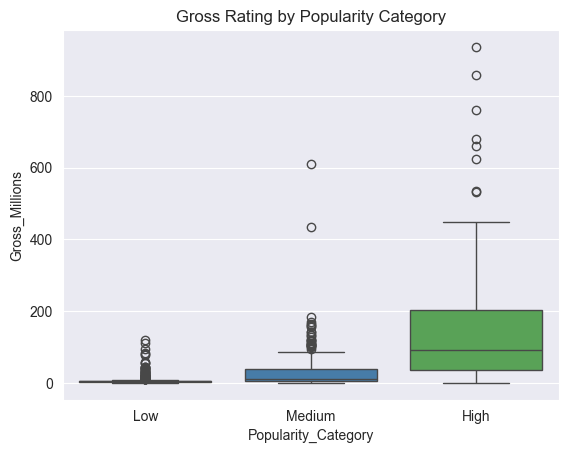

Average IMDB Rating Values for Each Popularity Category:
Popularity_Category
Low         7.59
Medium     29.33
High      134.73
Name: Gross_Millions, dtype: float64


In [4]:
# CLASSIFY POPULARITY AND CONTROL THE BALANCE OF DISTRIBUTION

# To see the range of votes
min_votes=df["No_of_Votes"].min()
max_votes=df["No_of_Votes"].max()
min_vote_movie = df.loc[ # df.loc[] pandas’ta etiket (label) tabanlı veri seçme yöntemi
    df["No_of_Votes"] == min_votes, "Series_Title"
].values[0]
max_vote_movie = df.loc[
    df["No_of_Votes"] == max_votes, "Series_Title"
].values[0]
print(f"Min Vote: {min_votes} - Movie Name: {min_vote_movie}")
print(f"Max Vote: {max_votes} - Movie Name: {max_vote_movie}")

# Classify Popularity into 3 Categories
df["Popularity_Category"] = pd.qcut(
    df["No_of_Votes"],
    q=3,
    labels=["Low", "Medium", "High"]
)
print(
    df["Popularity_Category"].value_counts()
)

# To See IMDB Rating or Gross By Category

# Making new column "Gross_Millions" and creating imdb_gross_mean
df["Gross_Millions"] = df["Gross"] / 1_000_000
imdb_gross_mean = (
    df.groupby("Popularity_Category")[["IMDB_Rating", "Gross_Millions"]]
    .mean()
    .round(2)
)

sns.boxplot(
    data=df,
    x="Popularity_Category",
    y="IMDB_Rating",
    palette="Set2"
)
plt.title("IMDB Rating by Popularity Category")
plt.show()
print("Average IMDB Rating Values for Each Popularity Category:")
print(imdb_gross_mean["IMDB_Rating"])

sns.boxplot(
    data=df,
    x="Popularity_Category",
    y="Gross_Millions",
    palette="Set1"
)
plt.title("Gross Rating by Popularity Category")
plt.show()
print("Average IMDB Rating Values for Each Popularity Category:")
print(imdb_gross_mean["Gross_Millions"])

Gross<100K: 36
Min Gross: 1305.0
Max Gross: 936662225.0
Mean Gross: 57273717.976
                                   Series_Title           Gross  \
477  Star Wars: Episode VII - The Force Awakens  936,662,225.00   

             Budget   ROI  
477  249,051,361.55  2.76  
            Series_Title           Gross         Budget   ROI
234  Million Dollar Baby  100,492,203.00  28,877,224.64  2.48


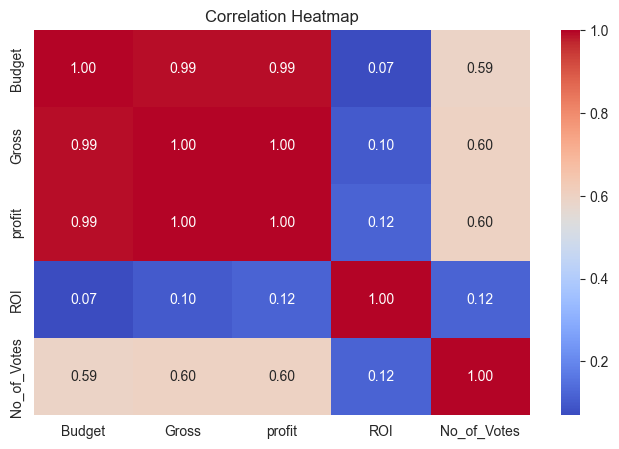

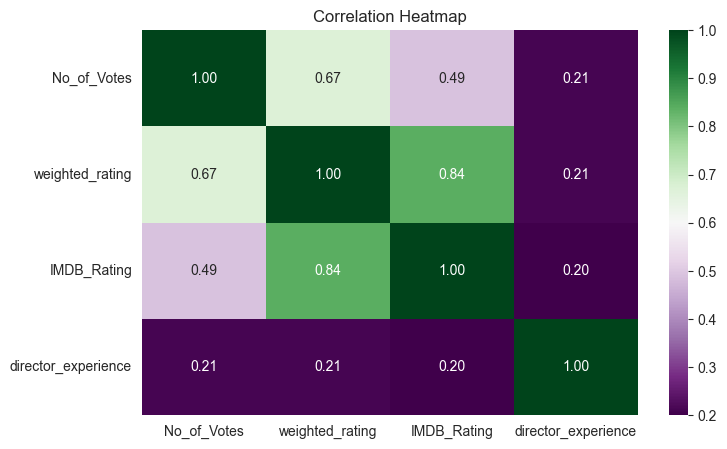

In [5]:
# WEIGHTED RATING CALCULATION (Amaç, az oy alan filmlerin yüksek puanlarının adil bir şekilde düşürülmesi ve çok oy alan filmlerin puanlarının daha güvenilir kabul edilmesidir)

import numpy as np
np.random.seed(42)

c = df["IMDB_Rating"].mean()
m = df["No_of_Votes"].quantile(0.90) # 90% oy alan filmleri alır, popüler filmleri ön plana çıkarır
def weighted_rating(x, m=m, c=c):
    v = x["No_of_Votes"] # v -> oy sayısı
    r = x["IMDB_Rating"] # r -> imdb puan
    return (v/(v+m) * r) + (m/(m+v) * c)
df["weighted_rating"] = df.apply( # fonksiyonu DataFrame’in her satırına uyguluyor
    weighted_rating, # her satırda çalışan fonksiyon
    axis=1
).round(2)

# CREATING NEW COLUMNS

# Find number of cast members and crew members
df["num_cast"] = 4
df["num_crew"] = df["num_cast"] + 1

# Count film number of each director
df["director_experience"] = df.groupby("Director")["Director"].transform("count")

# Find number of genres and main genre
df["genre_count"] = df["Genre"].apply(
    lambda x: len(x.split(",")) # lamda anonim fonksiyon / fonksiyonu ayrı bir isimle tanımlamadan tek satırda yazarak kolaylık sağlar
)
df["main_genre"] = df["Genre"].apply(
    lambda x: x.split(",")[0] # split(",") → yazıyı listeye çevirir "Drama, Action" → ["Drama", "Action"]
)

# Calculate Profit and ROI

df["Budget"] = (
    df["Gross"] * np.random.uniform(
        0.2, 0.3, size=len(df) # Herfilm için 0.2-0.3 arsnda rastgele çarpan üretilir, bylce 2 film aynı Gross'a sahip olsada bütçeleri farklı olabilir
    )
)
df["Budget"] = df["Budget"].clip( # amaç: Olası çok uçuk veya mantıksız bütçeleri sınırlamak / finansal mantık hatalarını temizler
    lower=1e5, # En düşük bütçeyi 100.000 $ ile sınırlandırır
    upper=df["Gross"] * 0.9 # Bütçe asla Gross'un %80’nını geçemez / ROI’nun pozitif ve gerçekçi aralıklarda kalmasını sağlar
)

df["profit"] = df["Gross"] - df["Budget"]
df["ROI"] = df["profit"] / (df["Budget"]+1) # roi = yatırımın geri dönüşü

min_gross = df["Gross"].min()
max_gross = df["Gross"].max()
mean_gross = df["Gross"].mean()
gross_less_than_100k = df[
    df["Gross"]<100_000
]
print(
    f"Gross<100K: {len(gross_less_than_100k)}"
)
print(f"Min Gross: {min_gross}")
print(f"Max Gross: {max_gross}")
print(f"Mean Gross: {mean_gross}")

movie_name = "Star Wars: Episode VII - The Force Awakens"
movie_data = df.loc[df["Series_Title"] == movie_name, ["Series_Title", "Gross", "Budget", "ROI"]].copy()
movie_data["ROI"] = movie_data["ROI"].round(2)
movie_data["Budget"] = movie_data["Budget"].apply(lambda x: f"{x:,.2f}")
movie_data["Gross"] = movie_data["Gross"].apply(lambda x: f"{x:,.2f}")
print(movie_data) # 💰 Real Budget: ≈ 30 milyon USD / 📊 Real ROI = 2.35

movie_name = "Million Dollar Baby"
movie_data = df.loc[df["Series_Title"] == movie_name, ["Series_Title", "Gross", "Budget", "ROI"]].copy()
movie_data["ROI"] = movie_data["ROI"].round(2)
movie_data["Budget"] = movie_data["Budget"].apply(lambda x: f"{x:,.2f}")
movie_data["Gross"] = movie_data["Gross"].apply(lambda x: f"{x:,.2f}")
print(movie_data) # 💰 Real Budget: ≈ 30 milyon USD / 📊 Real ROI = 2.35

# CORRELATION ANALYSIS 1
num_features = ["Budget", "Gross", "profit", "ROI", "No_of_Votes"]
corr = df[num_features].corr().round(2)

plt.figure(figsize=(8,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# CORRELATION ANALYSIS 2
num_features = ["No_of_Votes", "weighted_rating", "IMDB_Rating", "director_experience"]
corr = df[num_features].corr().round(2)

plt.figure(figsize=(8,5))
sns.heatmap(corr, annot=True, cmap="PRGn", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()